# Practical Examples

In [32]:
from typing import Union, Optional, List, Dict, Tuple, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf

import myforestplot as mfp

%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -n -u -v -iv -w -p graphviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu Sep 22 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.0.1

graphviz: not installed

matplotlib  : 3.5.1
pandas      : 1.4.1
statsmodels : 0.13.2
numpy       : 1.21.5
myforestplot: 0.2.2

Watermark: 2.3.1



## American National Election Studies of 1996
In this example, we will explore how to use myforestplot step by step.
The dataset is about American National Election Studies of 1996. We explore characteristics voters who vote to Dole (1) or Clinton (0).

Load dataset. Dataset explanation can be found [here](https://www.statsmodels.org/devel/datasets/generated/anes96.html).

In [271]:
data = sm.datasets.anes96.load_pandas().data

In [272]:
data.head()

,popul,TVnews,selfLR,ClinLR,DoleLR,PID,age,educ,income,vote,logpopul
0,0.0,7.0,7.0,1.0,6.0,6.0,36.0,3.0,1.0,1.0,-2.302585
1,190.0,1.0,3.0,3.0,5.0,1.0,20.0,4.0,1.0,0.0,5.247550
2,31.0,7.0,2.0,2.0,6.0,1.0,24.0,6.0,1.0,0.0,3.437208
3,83.0,4.0,3.0,4.0,5.0,1.0,28.0,6.0,1.0,0.0,4.420045
4,640.0,7.0,5.0,6.0,4.0,0.0,68.0,6.0,1.0,0.0,6.461624


Cleaning dataset. 

In [306]:
c = "TVnews"
dataM = data.copy()
dataM[c] = (dataM[c]
         .mask(data[c] <= 7, "frequent")
         .mask(data[c] <= 5, "moderate")
         .mask(data[c] <= 3, "seldom")
         )

c = "income"
dataM[c] = (dataM[c]
          .mask(data[c] <= 24, "11-24")
          .mask(data[c] <= 10, "0-10")
          )

# include missing
c = "age"
dataM[c] = (dataM[c]
          .mask(data[c].isnull(),"missing")
          .mask(data[c] <=100, "81-100")
          .mask(data[c] <=80, "61-80")
          .mask(data[c] <=60, "41-60")
          .mask(data[c] <=40, "19-40")
          )

c = "logpopul"
dataM[c] = (dataM[c]
          .mask(data[c] <= 9, "high")
          .mask(data[c] <= 4.70, "moderate high")
          .mask(data[c] <= 3.09, "moderate low")
          .mask(data[c] < 0.09, "low")
          )

c = "PID"
cates_PID = ["Strong Democrat","Weak Democrat","Independent-Democrat",
             "Independent-Indpendent", "Independent-Republican",
             "Weak Republican", "Strong Republican"]
rep_dic = {i:c for i,c in enumerate(cates_PID)} 
dataM[c] = dataM[c].replace(rep_dic)

c = "selfLR"
cates_selfLR = ["Strong Democrat","Weak Democrat","Independent-Democrat",
                "Independent-Indpendent", "Independent-Republican",
                "Weak Republican", "Strong Republican"]
rep_dic = {i+1:c for i,c in enumerate(cates_selfLR)}
dataM[c] = dataM[c].replace(rep_dic)

# include missing
c = "educ"
cates_educ = ["1-8 grades","Some high school", "High school graduate",
              "college", "College degree", "Master's degree", "PhD"]
rep_dic = {i+1:c for i,c in enumerate(cates_educ)}
dataM[c] = dataM[c].replace(rep_dic)

Fit logistic regression.

In [307]:
formula = "vote ~ TVnews + selfLR + PID + C(age, Treatment('41-60')) + educ + income + logpopul"
res = smf.glm(formula=formula,data=dataM, family = sm.families.Binomial()).fit()

If explanatory variables include continuous variables, specify it. In this case, we do not have any continous variables. Also, we have to specify item orders if variables are ordinal variables. 

In [308]:
cont_cols = []
item_order = {
    "TVnews": ["seldom", "moderate", "frequent"],
    "income": ["0-10", "11-24"],
    "age": ['19-40', '41-60', '61-80', '81-100'],
    "logpopul": ["low", "moderate low", "moderate high", "high"],
    "PID": cates_PID,
    "selfLR": cates_selfLR,
    "educ": cates_educ,
}
df = mfp.statsmodels_pretty_result_dataframe(dataM, res, 
                                             cont_cols=cont_cols, 
                                             item_order=item_order,
                                             fml=".3f", 
                                             )

After obtaining dataframe to be drawn, text position is required to be adjusted in order to draw beuatifully.

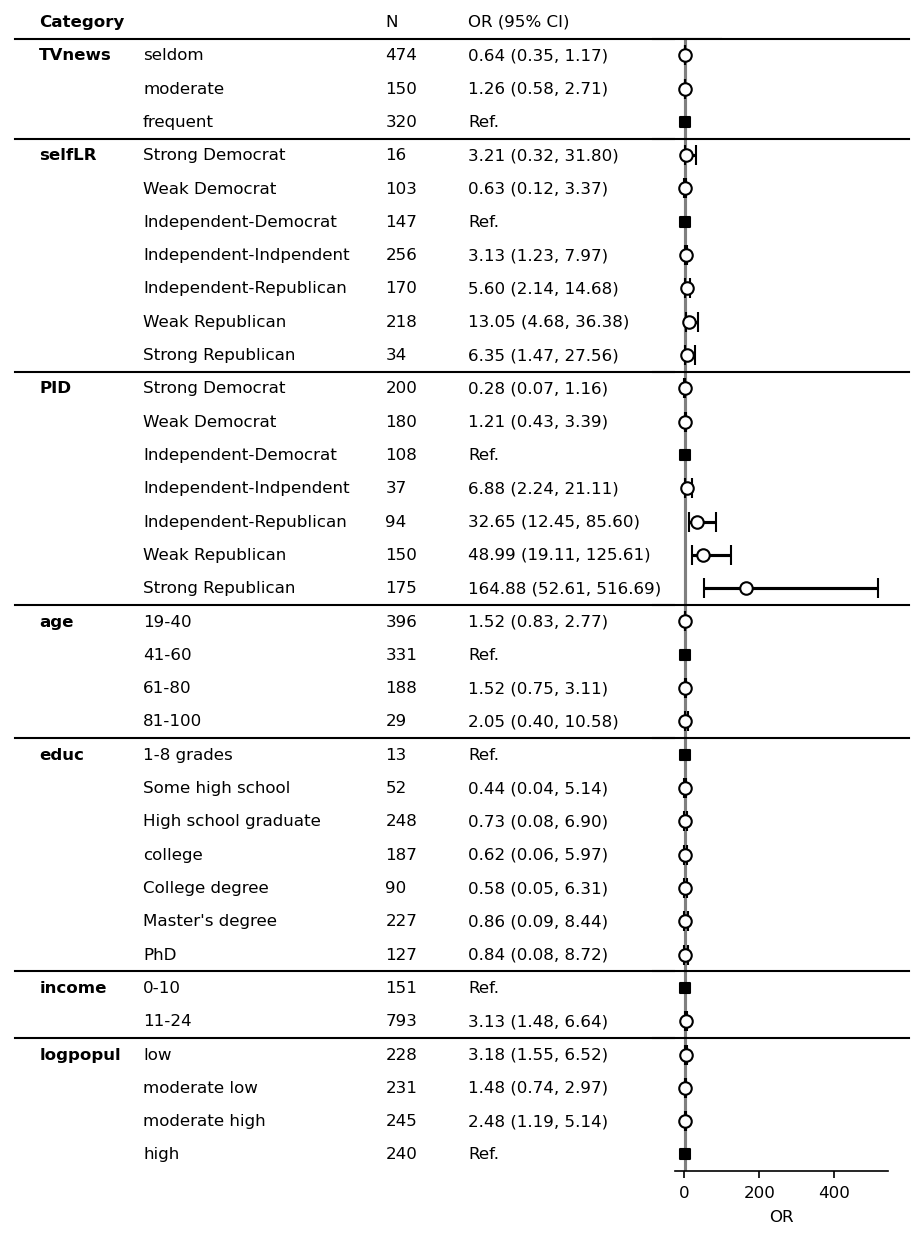

In [309]:
plt.rcParams["font.size"] = 8
fp = mfp.SimpleForestPlot(ratio=(8,3), dpi=150, figsize=(7,10), df=df)
fp.errorbar(errorbar_kwds=None)
fp.ax2.set_xlabel("OR")
fp.ax2.axvline(x=1, ymin=0, ymax=1.0, color="black", alpha=0.5)

fp.ax1.set_xlim([0.15, 1])
fp.embed_strings("category", 0.1, header="Category", 
                 duplicate_hide=True, 
                 text_kwds=dict(fontweight="bold"),
                 header_kwds=dict(fontweight="bold")
                 )
fp.embed_strings("item", 0.25, header="", replace={"age":""})
fp.embed_strings("nobs", 0.60, header="N")
fp.embed_strings("risk_pretty", 0.72, header="OR (95% CI)")
fp.horizontal_variable_separators()
plt.show()

Since some of the confidence intervals are very wide, first we convert OR to be drawn in log scale. To do so, just add log_scale=True for errorbar. For interpretation purpose, we also add xticks to be real number of odds (not log odds). 

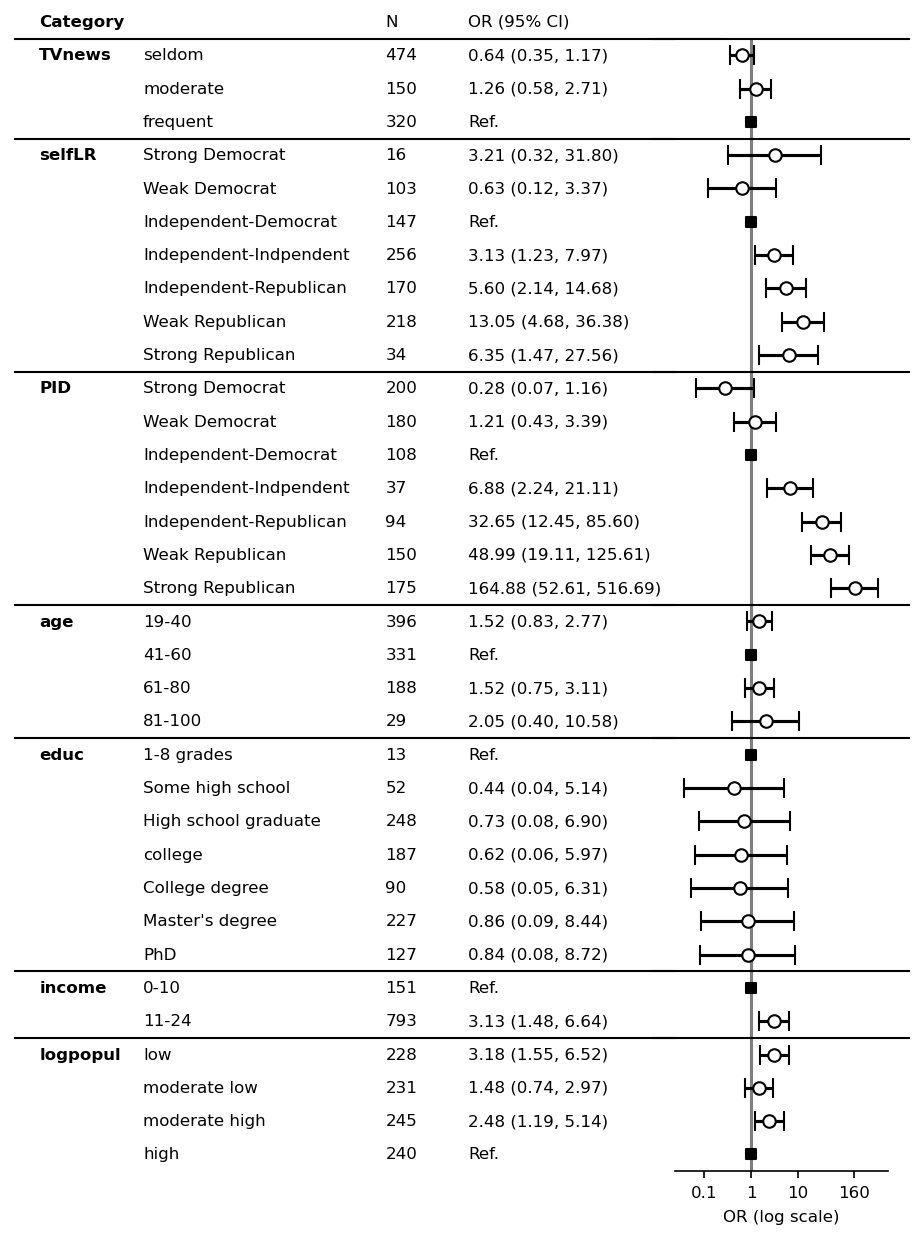

In [310]:
plt.rcParams["font.size"] = 8
fp = mfp.SimpleForestPlot(ratio=(8,3), dpi=150, figsize=(7,10),  df=df)
### These lines are changed.
fp.errorbar(errorbar_kwds=None, log_scale=True)
xticklabels = [0.1, 1, 10, 160]
fp.ax2.set_xticks(np.log(xticklabels))
fp.ax2.set_xticklabels(xticklabels)
fp.ax2.set_xlabel("OR (log scale)")
# Since reference becomes 0 for log scale, please also change x of axvline.
fp.ax2.axvline(x=0, ymin=0, ymax=1.0, color="black", alpha=0.5)
###

fp.ax1.set_xlim([0.15, 1])
fp.embed_strings("category", 0.1, header="Category", 
                 duplicate_hide=True, 
                 text_kwds=dict(fontweight="bold"),
                 header_kwds=dict(fontweight="bold")
                 )
fp.embed_strings("item", 0.25, header="", replace={"age":""})
fp.embed_strings("nobs", 0.60, header="N")
fp.embed_strings("risk_pretty", 0.72, header="OR (95% CI)")
fp.horizontal_variable_separators()
plt.show()

Some of the values are too large to be shown, use draw_outer_marker method to not show these.

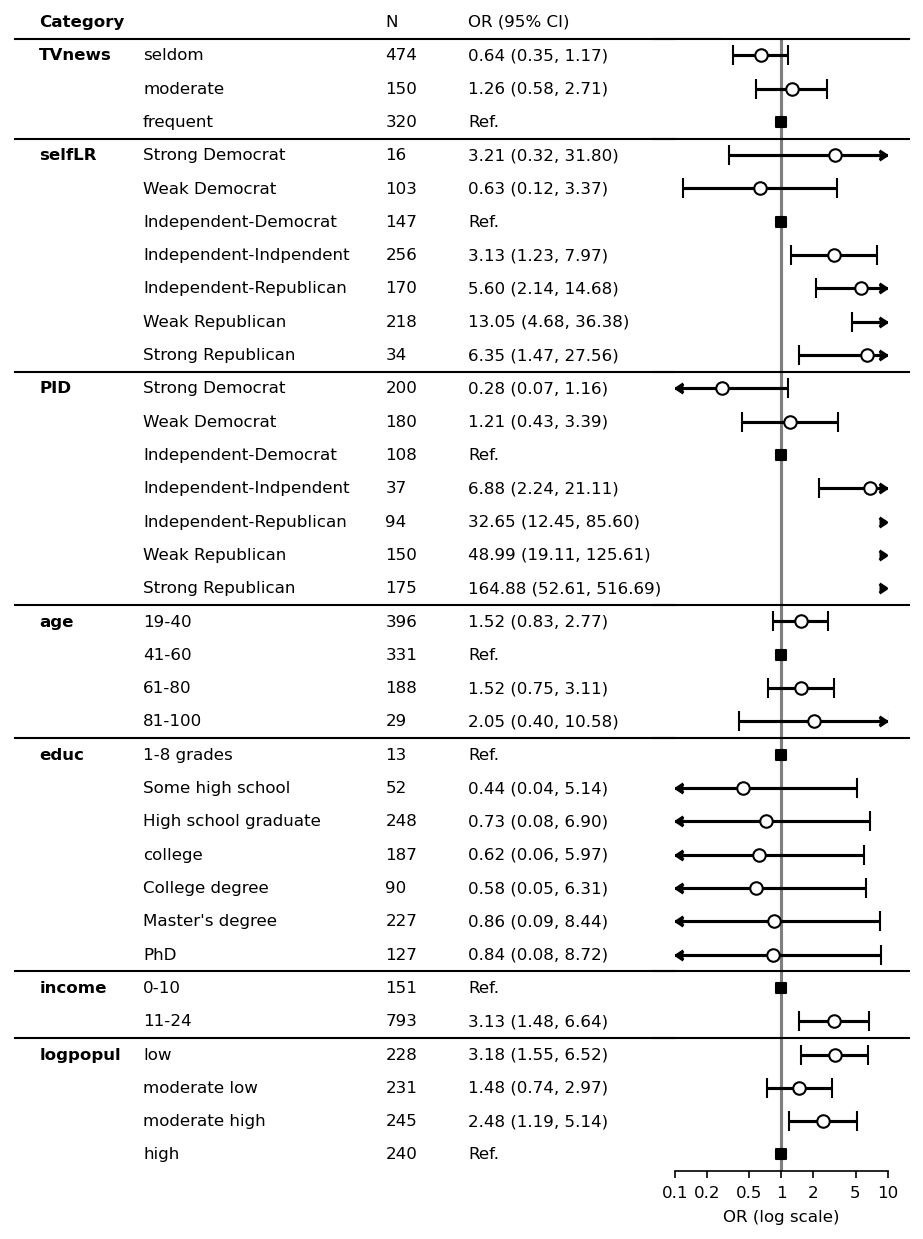

In [311]:
plt.rcParams["font.size"] = 8
fp = mfp.SimpleForestPlot(ratio=(8,3), dpi=150, figsize=(7,10),  df=df)
fp.errorbar(errorbar_kwds=None, log_scale=True)
### This line is changed.
xticklabels = [0.1, 0.2, 0.5, 1, 2, 5, 10]
### This line is added.
fp.ax2.set_xlim(np.log([0.1, 10]))
fp.ax2.set_xticks(np.log(xticklabels))
fp.ax2.set_xticklabels(xticklabels)
fp.ax2.set_xlabel("OR (log scale)")
fp.ax2.axvline(x=0, ymin=0, ymax=1.0, color="black", alpha=0.5)
### This line is added.
fp.draw_outer_marker(log_scale=True, scale=0.008)

fp.ax1.set_xlim([0.15, 1])
fp.embed_strings("category", 0.1, header="Category", 
                 duplicate_hide=True, 
                 text_kwds=dict(fontweight="bold"),
                 header_kwds=dict(fontweight="bold")
                 )
fp.embed_strings("item", 0.25, header="", replace={"age":""})
fp.embed_strings("nobs", 0.60, header="N")
fp.embed_strings("risk_pretty", 0.72, header="OR (95% CI)")
fp.horizontal_variable_separators()
plt.show()

From this figure, we suspect those who are republication are tend to vote to Dove. Also, income is related with voters.